# Huffman Algorithm

## Introduction

In lossless coding information compression is achieved by mapping messages into binary strings of variable length. This mapping is called *symbol coding* and should satisfy 3 properties:
1. Unique decodability
2. Prefix codes (aka self-punctuating codes)
3. Minimal length

A necessary condition for unique decodability is given by the *Kraft inequality*:
$$
    \sum_i 2^{-l_i} \leq 1
$$
where $l_i$ is the length of the codeword $i$. A code that saturates the Kraft inequality is called *complete code*, and it is possible to prof that there is a one-to-one correspondence between complete prefix codes and complete binary trees. In other words, prefix codes built from complete binary graphs saturate the inequality.

## Source coding theorem for symbol codes
For a random variable $X \in \mathcal{A}_X$ there exists a symbol code $E$ satisfying:
$$
    H[X] \leq L(E,X) \leq H[X] +1 
$$
Moreover, for all symbol codes $E'$ satisfying Kraft inequality we have that $L(E', X) \geq H[X]$.

## Huffman Algorithm
It is possible to realize an algorithm to find optimal codes, i.e. prefix codes with minimal length. Recall that minimal length is achived in terms of average length of the encoded message, so what we want to minimize is $ L[E,X] = \sum _i p_i l_i$. The Huffman Algorithm allows to build optimal codes using a recursive procedure to construct an optimal binary tree, starting from the leaves. 

The algorithm's steps are the following:
1. Create nodes for all elementary outcomes
2. Identify a pair of nodes associated to events with lowest probability
3. Create a parent node having these two outcomes as children
4. Iterate the procedure, considering only nodes with no parents
5. Stop when only 1 node without parents is left

Notice that the selection in step (2) might not be unique, so there can be different optimal codes, and the solution given by the Huffman Algorithm is not unique. 

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import re
import graphviz
from IPython.display import display_png

%matplotlib inline

In [22]:
def Huffman_Algorithm(probabilities, return_tree=False):
    '''
    INPUT:
    - probabilities: numpy array of probabilities 
    - return_tree: if true, return the tree
        
    OUTPUT:
    - codewords: list of binary strings associated to each event (aka, the symbol code)
    - tree_construction: the step by step construction of the binary tree. It is return as a list where each element contains the parent nodes at step i.
            
    '''
    
    # check if input are numpy arrays
    assert isinstance(probabilities, np.ndarray), 'probabilities must be a numpy array'
    
    # vector of events like (x1, x2, x3, ...)
    n_events = len(probabilities)
    myevents = np.array(['x'+str(i+1) for i in range(n_events)])
        
    if return_tree is True:
        tree_construction = [myevents]
    
    # initialization
    codewords = ['']*n_events
    
    prob_noparent = probabilities
    node_noparent = np.array(myevents)
    
    num_nodes_noparent = n_events    
    
    # algorithm 
    while num_nodes_noparent > 1:
        # select a pair of nodes with lowest probability
        mask = np.sort(np.argsort(prob_noparent)[:2])
        
        selected_probs  = prob_noparent[mask]
        selected_events = node_noparent[mask]
        
        # update codewords
        index_0 = np.array(re.findall(r'\d+', selected_events[0])).astype(int)-1
        index_1 = np.array(re.findall(r'\d+', selected_events[1])).astype(int)-1
        
        for i in index_0:
            codewords[i] = '0' + codewords[i]
    
        for i in index_1:
            codewords[i] = '1' + codewords[i] 
        
        # update probabilities and events without parents
        prob_noparent = np.append(np.delete(prob_noparent, mask), sum(selected_probs))
        node_noparent = np.append(np.delete(node_noparent, mask), selected_events[0]+selected_events[1])
        
        # update tree if required
        if return_tree:
            selection = tree_construction[-1][mask]
            tree_construction.append(np.append(np.delete(tree_construction[-1], mask), selection[0]+selection[1]))
   
        num_nodes_noparent -= 1
        
    if return_tree is True:
        return codewords, [x.tolist() for x in tree_construction]

    else:            
        return codewords


def avg_length(probabilities, encoding):
    '''
    INPUT:
    - probabilities: numpy array of probabilities 
    - encoding: list of binary strings associated to each probability 
        
    OUTPUT:
    - LE: average length
    
    '''
    
    LE = np.dot(probabilities, np.array([len(code) for code in encoding]))
    return LE


def kraft_inequality(encoding):
    '''
    INPUT: 
    - encoding: list of binary strings associated to each probability 
        
    OUTPUT:
    - True if Kraft inequality is satisfied, False otherwise
    
    '''
    
    kraft_bound = sum(np.exp2([-len(code) for code in encoding]))
    
    if kraft_bound<=1:
        return True
    else:
        return False
    

In [23]:
def entropy(p):
    return np.dot(p, -np.log2(p))

In [45]:
def plot_tree(HC_steps):
    '''
    INPUT: 
    - HC_steps: steps of the Huffman Algorithm 
        
    OUTPUT:
    - f: resulting binary tree 
    
    '''
    
    # inizialize the tree
    f = graphviz.Digraph('mytree')
    
    for x in HC_steps[0]:
        f.node('L0_'+x, label=x)
    
    for i in range(1, len(HC_steps)):
        # find new root and corresponding leaves
        [root] = [item for item in HC_steps[i]   if item not in HC_steps[i-1]] #1
        leaves = [item for item in HC_steps[i-1] if item not in HC_steps[i]]   #2
        
        # compute levels        
        lev_r = len(re.findall(r'\d+', root))-1
        lev_l0 = len(re.findall(r'\d+', leaves[0]))-1
        lev_l1 = len(re.findall(r'\d+', leaves[1]))-1
        
        # find nodes names
        root_node = 'L'+str(lev_r)+'_'+root
        leaf_node_0 = 'L'+str(lev_l0)+'_'+leaves[0]
        leaf_node_1 = 'L'+str(lev_l1)+'_'+leaves[1]
        
        # create new node
        f.node(root_node, label=root)
        
        # create edges
        f.edge(root_node, leaf_node_0, label='0')
        f.edge(root_node, leaf_node_1, label='1')
        
    return f

# Testing the algorithm
## Test 0
First I test it considering 4 events with associated probabilities: $P_X= \{1/2, 1/4, 1/8, 1/8\}$

In [25]:
px_0 = np.array([1/2, 1/4, 1/8, 1/8])

encoding_0, steps_0= Huffman_Algorithm(px_0, return_tree=True)

print('Code found by the Huffman Algorithm:')
for i in range(len(px_0)):
    print('x%i: %s' %(i+1, encoding_0[i]))

Code found by the Huffman Algorithm:
x1: 0
x2: 10
x3: 110
x4: 111


Let's compute the average length and compare it with the Shannon entropy of $X$. Let's see also if the Kraft inequality is satisfied or not.

In [26]:
print('Average length: L[E,X]=%.2f' %(avg_length(px_0, encoding_0)))
print('Shannon entropy:  H[X]=%.2f' %(entropy(px_0)))

print('\nIs Kraft inequality satisfied?', kraft_inequality(encoding_0))

Average length: L[E,X]=1.75
Shannon entropy:  H[X]=1.75

Is Kraft inequality satisfied? True


It is also possible to plot the resulting complete binary tree. 

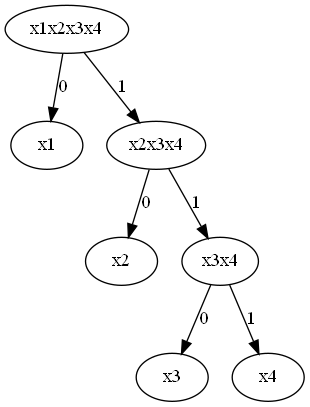

In [48]:
#plot_tree(steps_0)
display_png(plot_tree(steps_0))

## Test 1 
I repeat the same test using the data of homework 02. 

In [28]:
px_1 = np.array([1/4, 1/4, 1/4, 3/16, 1/64, 1/64, 1/64, 1/64])

encoding_1, steps_1 = Huffman_Algorithm(px_1, return_tree=True)

print('Code found by the Huffman Algorithm:')
for i in range(len(px_1)):
    print('x%i: %s' %(i+1, encoding_1[i]))

Code found by the Huffman Algorithm:
x1: 00
x2: 01
x3: 10
x4: 110
x5: 11100
x6: 11101
x7: 11110
x8: 11111


In [29]:
print('Average length: L[E,X]=%.3f' %(avg_length(px_1, encoding_1)))
print('Shannon entropy:  H[X]=%.3f' %(entropy(px_1)))

print('\nIs Kraft inequality satisfied?', kraft_inequality(encoding_1))

Average length: L[E,X]=2.375
Shannon entropy:  H[X]=2.328

Is Kraft inequality satisfied? True


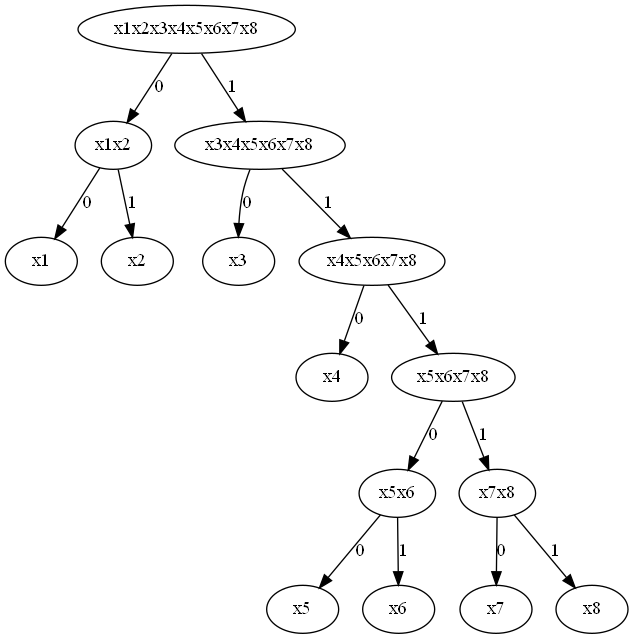

In [49]:
#plot_tree(steps_1)
display_png(plot_tree(steps_1))

## Test 2
Finally, I want to apply it to the text that was given to us in homework 1. In this case I associate a code to each word in the text, and the corresponding probability is given by its relative occurrence. In the preprocessing I will only convert the test to lowercase. 

In [31]:
from string import digits, punctuation

# import file
file = open('./text.txt')
mytext = file.read()

# preprocessing
mytext = mytext.replace('ACT V', 'ACT 5').replace('ACT IV', 'ACT 4').replace('ACT III', 'ACT 3').replace('ACT II', 'ACT 2').replace('ACT I', 'ACT 1')
mytext = mytext.replace('SCENE III', 'SCENE 3').replace('SCENE II', 'SCENE 2').replace('SCENE I', 'SCENE 1')

mytext = mytext.lower()


In [32]:
mytext_list = re.findall(r"[\w]+|[^\s\w]", mytext)

# occurrences of unique words in the list
values, counts = np.unique(mytext_list, return_counts=True)
print('Number of unique words in the text (+ punctuation):', len(values))

# probability distribution
prob_text = counts/len(mytext_list)

Number of unique words in the text (+ punctuation): 3085


In [33]:
# Huffman Algorithm
encoding_text = Huffman_Algorithm(prob_text)

print('Average length: L[E,X]=%.3f' %(avg_length(prob_text, encoding_text)))
print('Shannon entropy:  H[X]=%.3f' %(entropy(prob_text)))

print('\nIs Kraft inequality satisfied?', kraft_inequality(encoding_text))

Average length: L[E,X]=8.693
Shannon entropy:  H[X]=8.658

Is Kraft inequality satisfied? True


In [34]:
ex_ = [0, 1000, 2000, 3000]
print('Some examples of wordcodes:')

for ex in ex_:
    print("'%s' -> %s" %(values[ex], encoding_text[ex]))

Some examples of wordcodes:
'!' -> 1110100
'flatterer' -> 111110010011000
'popular' -> 00000100000010
'willing' -> 111100110100111


In [35]:
i = np.argmax(prob_text)
j = np.argmin(prob_text)

print('Encoding of the most probable word:')
print("'%s' -> %s" %(values[i], encoding_text[i]))

print('\nEncoding of the less probable word:')
print("'%s' -> %s" %(values[j], encoding_text[j]))

Encoding of the most probable word:
',' -> 1100

Encoding of the less probable word:
'4' -> 111100111101110
